# Introduction to ADVISER 2.0 Services

In this tutorial, we will discuss Services which are the backbone of the ADVISER 2.0 toolkit and allow for the creation of multi-modal dialog systems.

## Overview
* [What are Services](#intro)
* [Implementing a Service](#implementation)
* [Instantiating a Dialog System](#instantiating)
* [Debugging a Dialog System](#debugging)
* [Running a Dialog System](#running)

## What are Services? <a class="anchor" id="intro"></a>

A dialog system created with *ADVISER 2.0* is constructed from *services*, with a service for each module from the modular dialog system graph shown in the previous tutorial.
Each service receives inputs from previous services, processes them, and then passes the results on to the next services. An example of this can be seen in the dialog system graph below:

<img src="system.png" width="25%" height="25%" />

Each block represents one service (module) in the dialog system and each arrow represents the inputs/outputs of that service. To communicate with each other, services use a publisher/subscriber pattern. This will be explained later in this tutorial, but basically means, that a service defines a list of inputs it expects and that it outputs. The service is then asynchronously called once all the expected inputs are available.


**Example:**

Let's take the `HandcraftedNLU` service class as an example:
* The service receives a string *user_utterance* as input
    * It is important to note: the source of this input is unknown to the service and does not matter. In this example, it comes from the console, but it could just as easily come from a GUI or an automatic speech recognition (ASR) service

* The service outputs a list of user acts extracted from the user utterance
    * The receiver(s) of the outputs is not known to the service and does not matter
    
In summary, a service does not posess nor require any knowledge about a dialog system - its purpose is to process a piece or stream of information and send the result out so other services might use it. This allows dialog systems to be created where it is very easy to swap out (or combine) different services. 

### Publish Subscribe at a high level
Information is passed between services using the publisher/subscriber pattern which enables for asynchronous communication between services:
* A Publisher *publishes* messages to a certain *topic* (where a topic is just a string specifying the name of an information channel)
* A Subscriber *subscribes* to a certain topic, and is notified everytime a new message is published to this topic

If a method is a subscriber, it is automatically called as soon as it has recieved a message for each of the topics it subscribes to. This means that rather than relying on a traditional linear architecture, where each module in the dialog system must be called sequentially, we can break away and allow modules to run arbitrarily in parallel - which is critical for handling multimodal input which might need continuous processing. 

As a note, methods in a service class may act as both a publisher and a subscriber, only one, or neither.

## Implementing a Service <a class="anchor" id="implementation"></a>

With this terminology in mind, let's look at the way a service subscribes to and publishes messages. As a first step we'll handle all the imports needed for this tutorial.

In [1]:
# FIRST SET UP ENVIRONMENT

import sys
import os
from typing import List
import time
sys.path.append(os.path.abspath('../..'))

from services.service import Service, PublishSubscribe, RemoteService
from utils.topics import Topic
from services.service import DialogSystem
from utils.domain.domain import Domain
from utils.logger import DiasysLogger, LogLevel

### Creating our First Service

For our first service, we are going to make a simple class with a method that subscribes to two input topics, "A" and "B" and can publish to two output topics: "C" and "D". The code for this can be seen below:

In [2]:
class ConcatenateService(Service):

    @PublishSubscribe(sub_topics=["A", "B"], pub_topics=["C", "D"])
    def concatenate(self, A: int = None, B: str = None) -> dict(C=str,D=str):
        """
            A method to concatenate the content of two input topics and conditionally publish to either
            topic "C" or topic "D"
            
            Args:
                A (int): message for topic "A"
                B (str): message for topic "B"
            Return:
                (dict): dictionary where key is the topic to be published to (conditionally "C" or "D"
                        depending on whether the value of A is 3) and the value is the concatenation
                        of inputs A and B
        """
        print("CONCATENATING ", A, "AND ", B)
        result = str(A) + " " + B
        if A == 3:
            return {'D': result}
        else:
            return  {'C': result}

**Inheriting from the Service class:**

* Any service that wants to send / receive messages in the ADVISER 2.0 system must inherit from `services.service.Service`.
This class handles the communication mechanisms between services and makes sure the service is properly registered with the dialog system so that messages are properly delivered to and received by the appropriate services.

**Decorating Methods with PublishSubscribe:**

* Each service method that should send / receive messages must be decorated with the `services.service.PublishSubscribe` decorator. Let's have a look at the decorator arguments:
    * `sub_topics`: a list of topics the method needs as inputs. 
       * The method will be called as soon as *at least 1 message for each subscribed topic has been received* and in cases where multiple messages for a topic are received,  only the most recent message will be used.
       * *Every topic in the sub_topics list, must be also be included as a method argument with the same name*. This allows the system to map message content to method arguments.

    * `pub_topics`: a list of topics the function wants to publish messages to.
      You don't have to publish anything during a function call, even if you include entries in the `pub_topics` list.
      But if you do want to publish a message, make sure:
         * *Only publish dictionaries!* Otherwise, the system does not know what topic to send your return values to
         * You are free to choose not to publish to all topics declared in *pub_topics*
            * In our example, we have the option to publish to topic `C` and to topic `D`, but this method will only to publish to one or the other depending on the message content of `A`
         * Dictionary keys must correspond to the topics in the `pub_topics` list

**Example:**

<img src="message_order.png" width="50%" height="50%"/>

Assume the decorated function receives the following input as shown above:

   1. `A: 1`
   2. `A: 2`
   3. `A: 3`
   4. `B: "dropped Messages"`
   
       
How will the concatenate method be called:
* The `concatenate` method will only be called after the fourth message, because this is the first time where at least one message per topic is available (3 messages for `A`, 1 for `B`).
* Since only the most recent messages will be used, the function will receive the following input: (`A=3`, `B="dropped Messages"`)
* The variable `result` will thus contain the string `3 dropped Messages` and this will be publised to topic `D`
* As a note: There are  mechanisms for collecting all messages instead of dropping them, but those will be introduced later.

### Creating a Second Service

Finally, we need a second service which is responsible for generating the messages for topics `A` and `B`. This new service will also be responsible for shutting down the dialog loop when the example is over, by publishing `True` to the topic `DIALOG_END`. This topic is one of the default control message topics and is required to end a dialog. When we create our first dialog system, we will explain this in more detail. For now, let's take a look at our second service:

In [3]:
class PrintService(Service):
    @PublishSubscribe(sub_topics=["D"], pub_topics=[Topic.DIALOG_END])
    def print_d(self, D: str):
        """
            A method which prints the content of topic D and then publishes the end dialog signal
            
            Args:
                D (str): content of topic D, represents the output of the method concatenate
            Return:
                (dict): key represents the topic DIALOG_END which should be publsihed to with the value True
        """
        print(f"RECEIVED D={D}")
        return {Topic.DIALOG_END: True}

    @PublishSubscribe(sub_topics=["start"])
    def turn_start(self, start: bool = True):
        """
            A method to start the example communication, it waits for the signal to start the dialog and
            then calls the send_a method three times followed by the send_b method once
            
            Args:
                start (bool): The signal to start the dialog system (will be published by whatever DialogSystem
                              object that this class is registered to)
        """
        a = 1
        while a < 4:
            time.sleep(0.5)
            self.send_a(a)
            a += 1
        time.sleep(0.5)
        self.send_b()

    @PublishSubscribe(pub_topics=["A"])
    def send_a(self, a: int):
        """
            A method to print a given integer a and then publish it to topic "A"
            
            Args:
                a (int): the integer to publish to topic "A"
            Return:
                (dict): where the key is "A" (topic to publish to) and the value is the given int a
        """
        print("SENDING A=", a)
        return {'A': a}

    @PublishSubscribe(pub_topics=["B"])
    def send_b(self):
        """
            A method to publish "messages dropped!" to topic "B"
            
            Return:
                (dict): where the key is "B" (topic to publish to) and the value is "messages dropped!"
        """        
        print("SENDING B")
        return {'B': "messages dropped!"}


**print_d():**

This method subscribes to the content of topic `D` and when it receives a message, prints the content and publishes a signal to `DIALOG_END` to finish the dialog.

**turn_start():**

This method is called once it receives a message from the `start` topic. It then sends three messages to topic `A` (by calling `send_a`) and one message to topic `B` (by calling `send_b`).
The `sleep` calls are inserted here so we can watch the messages in the correct order (which is otherwise not guaranteed, since this is a multithreaded system). In real applications, such sleep statements are not necessary

**send_a():**

This method does not subscribe to anything, but publishes a given int `a` to topic `A`

**send_b():**

This method does not subscribe to anything, but publishes a given string `b` to topic `B`

## Instantiating and Shutting Down a Dialog System <a class="anchor" id="instantiating"></a>

With these two services, we can test the message behavior we just described. The first step is creating a dialog system and then registering these two services to it.
A dialog system is important, because it is responsible for handling synchronization and message passing, registering remote services, and providing debugging functionality.


### Creating a New Dialog System
To get started, we will create an instance of each of our services and register them with a dialog system by passing them in to the `services` parameter as a list:

In [4]:
concatenate_service = ConcatenateService()
print_service = PrintService()

In [5]:
ds = DialogSystem(services=[concatenate_service, print_service], debug_logger=None)

**Note:** Because a dialog system also sets up the communications pipelines for each of the services, it is important that you only have one dialog system active at a time. If you try to instantiate a new dialog system without shutting down the previous one, you will get an error as the ports are already in use. You can shut down the dialog system by typing: `ds.shutdown()`

## Debugging a Dialog System <a class="anchor" id="debugging"></a>

### Checking for Inconsistencies

To see if all of our required / offered service topics are actually connected to something, we can check the dialog system for inconsistencies:

In [6]:
ds.print_inconsistencies()


(Potential) Errors (subscribed topics without publishers):
  topic: 'start', subscribed to in services: {'PrintService'}


Warnings (published topics without subscribers):
  topic: 'C', published in services: {'ConcatenateService'}
  topic: 'dialog_end', published in services: {'PrintService'}



Here, we can see that `PrintService` has to receive an external `start`-topic message to be able to function - without that, `turn_start` will never be called. In this case, this is okay because the dialog system can provide this start message, however in a case where we would want start turn to be called multiple times, this would be a problem.
Additionally, we publish to topic `C` but no service subscribes to this.


As you can see, when your functions are not called as expected, this output might help you track down bugs in your system.

If you want to get even more detailed debug output (print all messages and associated topics), you can provide a `utils.logger.DiasysLogger` instance to the `debug_logger` argument of the `DialogSystem` constructor and to the constructor for each service you want to log information from.

### Displaying the System Graph

To get an overview of the system, we can also draw a graph of all services and their connections which is helpful to make sure that all services are connected in the ways that we thought they were. The code for drawing this graph can be seen below:

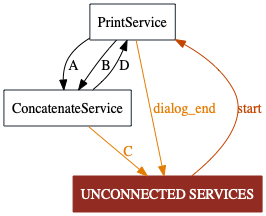

In [7]:
ds.draw_system_graph(name='tutorialgraph', show=False) # render image to tutorials/tutorialgraph.gv.png

# render image in jupyter notebook
from IPython.display import Image 
display(Image(filename='tutorialgraph.gv.png'))

You can see in the system graph that `PrintService` needs an outside message to a `start` topic (which in turn triggers the counter for $a=1,\dots,3$).
Both topics, `A` and `B`, are published by `PrintService` and subscribed to by `ConcatenateService`.
Similarly, `ConcatenateService` publishes to topic `C` and `D`, where `D` is subscribed to by `PrintService`.

`C` however is published but never subscribed to - which is shown by the arrow from `ConcatenateService` to the `UNCONNECTED SERVICES` node in the dialog graph.

### Logging

In order to debug more effectively, ADVISER 2.0 also comes with logging functionality through the class `utils.logger.DiasysLogger`. The logger has the option to log to the console and/or to a file with the following log levels:
* NONE: No information will be logged
* RESULTS: Summary information will be logged about the success rate/# of turns after an epoch of training/testing
* DIALOGS: All user/system utterances and summary statistics

The logger can be passed to any of the modules, to log that module's output, however when passed to the dialog system itself, the logger will additionally be able to log any messages sent through and all received by the dialog system - including the message's topic and content.

A DiasysLogger can be instantiated as below:

In [8]:
# create logger to log everything to a file
logger = DiasysLogger(console_log_lvl=LogLevel.NONE, file_log_lvl=LogLevel.DIALOGS)

And passed to a dialog system to log all message communication by passing it in with the `debug_logger` parameter on instantiation.

In [9]:
#ds = DialogSystem(services=[concatenate_service, print_service], debug_logger=logger)

## Running a Dialog <a class="anchor" id="running"></a>
To start a new dialog you can call the `DialogSystem` object's `run_dialog` method. When doing this, it is important to specify a `start_signal` in the form of a dictionary where keys are the topics the signal will be published to and values are the message content to be published.
We need an external signal because the `run_dialog` method is blocking and no function calls after `run_dialog` will be executed until the dialog sends an exit signal. Therefore, the start signal is an external one time message (or multiple messages) which kickstart the normal dialog loop. In our case, the start signal is to publish to the `start` topic and since the value of this is never used, we simply set it to `True`.

In [10]:
ds.run_dialog(start_signals={'start': True})
ds.shutdown()

SENDING A= 1
SENDING A= 2
SENDING A= 3
SENDING B
CONCATENATING  3 AND  messages dropped!
RECEIVED D=3 messages dropped!


... And we get exactly the output described in the previous section!
`concatenate` was only called after a message from both topics, `A` and `B`, arrived - and since `A` received multiple messages before `B`, those messages were dropped so only one concatenated string is printed.

Since the dialog system loop is blocking for a whole dialog, it is very important to make sure there is an end condition to close the loop (i.e. publishing `True` to the topic `DIALOG_END`). If none of our services did this,
this notebook code would be stuck after calling the `run_dialog` and no new code could be executed. To prove this is not the case, try running the code cell below :)

In [11]:
print("Not stuck in a dialog loop!")

Not stuck in a dialog loop!
